In [ ]:
#!pip install wordcloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
#nltk.download('all')
#nltk.download('punkt')
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from google.colab import drive
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re
import string
from wordcloud import WordCloud, STOPWORDS

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = '/content/gdrive/My Drive/Data_sets/Reviews.csv'
df = pd.read_csv(path)

In [ ]:
print(df.columns)
print(df.shape)

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
(568454, 10)


In [ ]:
count = df.groupby('ProductId', as_index=False).count()
mean = df.groupby('ProductId', as_index=False).mean()

In [ ]:
df1 = pd.merge(df, count, how='right', on=['ProductId'])
#rename columns
df1['Count'] = df1['UserId_y']
df1['Score'] = df1['Score_x']
df1['Summary'] = df1['Summary_x']
#Create New datafram with selected variables
df1 = df1[['ProductId','Summary','Score','Count']]
#Choose only products have over 100 reviews
df1 = df1.sort_values('Count', ascending=False)
df2 = df1[df1.Count >= 100]

In [ ]:
df4 = df.groupby('ProductId', as_index=False).mean()
combine_summary = df2.groupby("ProductId")['Summary'].apply(list)
combine_summary = pd.DataFrame(combine_summary)
combine_summary.to_csv('combine_summary.csv')

In [ ]:
#create with certain columns
df3 = pd.read_csv("combine_summary.csv")
df3 = pd.merge(df3, df4, on='ProductId', how='inner')
df3 = df3[['ProductId','Summary','Score']]

In [ ]:
#function for tokenizing summary
cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
	sentence = sentence.lower()
	sentence = cleanup_re.sub(' ', sentence).strip()
	sentence = " ".join(nltk.word_tokenize(sentence))
	return sentence

In [ ]:
#reset index and drop duplicate rows
df3['Summary_Clean'] = df3['Summary'].apply(cleanup)
df3 = df3.drop_duplicates(['Score'], keep='last')
df3 = df3.reset_index()

from pandas import DataFrame

In [ ]:
docs = df3['Summary_Clean']
vect = CountVectorizer(max_features = 100, stop_words='english')
X = vect.fit_transform(docs)

df5 = DataFrame(X.A, columns=vect.get_feature_names())
df5 = df5.astype(int)

In [ ]:
#save
df5.to_csv('df5.csv')

# First let's create a dataset called X
X = np.array(df5)
tpercent = 0.9
tsize = int(np.floor(tpercent * len(df5)))
df5_train = X[:tsize]
df5_test = X[tsize:]
#len of train and test
lentrain = len(df5_train)
lentest = len(df5_test)

In [ ]:
#KNN classifire to find similar products
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(df5_train)
distances, indices = nbrs.kneighbors(df5_train)

In [ ]:
#find most related products
for i in range(lentest):
	a = nbrs.kneighbors([df5_test[i]])
	related_product_list = a[1]
	first_related_product = [item[0] for item in related_product_list]
	first_related_product = str(first_related_product).strip('[]')
	first_related_product = int(first_related_product)
	second_related_product = [item[1] for item in related_product_list]
	second_related_product = str(second_related_product).strip('[]')
	second_related_product = int(second_related_product)
	print ("Based on product reviews, for ", df3["ProductId"][lentrain + i] ," and this average Score is ",df3["Score"][lentrain + i])
	print ("The first similar product is ", df3["ProductId"][first_related_product] ," and this average Score is ",df3["Score"][first_related_product])
	print ("The second similar product is ", df3["ProductId"][second_related_product] ," and this average Score is ",df3["Score"][second_related_product])
	print ("-----------------------------------------------------------")

Based on product reviews, for  B007TGDXMU  and this average Score is  4.517006802721088
The first similar product is  B005ZBZLPI  and this average Score is  4.0
The second similar product is  B000SDKDM4  and this average Score is  4.08252427184466
-----------------------------------------------------------
Based on product reviews, for  B007TGDXNO  and this average Score is  4.3478260869565215
The first similar product is  B007TGDXMK  and this average Score is  4.143540669856459
The second similar product is  B00451WLYI  and this average Score is  4.517647058823529
-----------------------------------------------------------
Based on product reviews, for  B007TJGY5K  and this average Score is  4.119496855345912
The first similar product is  B007L3NVKU  and this average Score is  4.355072463768116
The second similar product is  B0027Z8VES  and this average Score is  4.341269841269841
-----------------------------------------------------------
Based on product reviews, for  B007TJGZ0Y  an

In [ ]:
df5_train_target = df3["Score"][:lentrain]
df5_test_target = df3["Score"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_train_traget = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(df5_train, df5_train_target)
knnpreds_test = knnclf.predict(df5_test)
print(knnpreds_test)

print(classification_report(df5_test_target.round(), knnpreds_test))
print(accuracy_score(df5_test_target.round(), knnpreds_test))

[4 4 4 3 4 4 3 3 3 4 4 3 3 3 4 4 4 3 3 3 4 3 4 3 4 3 4 4 4 4 4 4 3 4 3 4 3]
              precision    recall  f1-score   support

         3.0       0.12      1.00      0.22         2
         4.0       0.71      0.54      0.61        28
         5.0       0.00      0.00      0.00         7

    accuracy                           0.46        37
   macro avg       0.28      0.51      0.28        37
weighted avg       0.55      0.46      0.48        37

0.4594594594594595


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
count = df.groupby("UserId", as_index=False).count()
mean = df.groupby("UserId", as_index=False).mean()

#merge two dataset create df1
df1 = pd.merge(df, count, how='right', on=["UserId"])
#rename column
df1["Count"] = df1["ProductId_y"]
df1["Score"] = df1["Score_x"]
df1["Summary"] = df1["Summary_x"]

#Create new datafram with selected variables
df1 = df1[["UserId",'Summary','Score',"Count"]]

In [ ]:
df1 = df1.sort_values('Count', ascending=False)
df2 = df1[df1.Count >= 100]

In [ ]:
df4 = df.groupby("UserId", as_index=False).mean()
combine_summary = df2.groupby("UserId")["Summary"].apply(list)
combine_summary = pd.DataFrame(combine_summary)
combine_summary.to_csv("combine_summary.csv")

In [ ]:
df3 = pd.read_csv("combine_summary.csv")
df3 = pd.merge(df3, df4, on="UserId", how='inner')
df3 = df3[['UserId','Summary','Score']]

In [ ]:
df3["Summary_Clean"] = df3["Summary"].apply(cleanup)

In [ ]:
df3 = df3.drop_duplicates(['Score'], keep='last')
df3 = df3.reset_index()

In [ ]:
from pandas import DataFrame
from sklearn.feature_extraction.text import  CountVectorizer
docs = df3["Summary_Clean"]
vect = CountVectorizer(max_features = 100, stop_words='english')
X = vect.fit_transform(docs)

df5 = DataFrame(X.A, columns=vect.get_feature_names())
df5 = df5.astype(int)

In [ ]:
df5.to_csv("df5.csv")
kkk = df.drop_duplicates(['Summary'], keep='last')
kkk = kkk.reset_index()

In [ ]:
#Frist let's create a dataset called X, with 6 record and 2 features each
X = np.array(df5)

tpercent = 0.95
tsize = int(np.floor(tpercent * len(df5)))
df5_train = X[:tsize]
df5_test = X[tsize:]

lentrain = len(df5_train)
lentest = len(df5_test)

nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(df5_train)

distances, indices = nbrs.kneighbors(df5_train)

In [ ]:
for i in range(lentest):
  a = nbrs.kneighbors([df5_test[i]])
  related_product_list = a[1]

  first_related_product = [item[0] for item in related_product_list]
  first_related_product = str(first_related_product).strip('[]')
  first_related_product = int(first_related_product)
  second_related_product = [item[1] for item in related_product_list]
  second_related_product = str(second_related_product).strip('[]')
  second_related_product = int(second_related_product)

  print("Based on reviews, for user is ", df3["UserId"][lentrain +i])
  print("The first similar user is ", df3["UserId"][first_related_product], ".")
  print("He/She likes following products")
  for i in range(295743):
    if (kkk["UserId"][i] == df3["UserId"][first_related_product]) & (kkk["Score"][i] == 5):
      aaa= kkk["ProductId"][i]

      print(aaa),
  print("--------------------------------------------------------------------")


Based on reviews, for user is  AY12DBB0U420B
The first similar user is  A3FKGKUCI3DG9U .
He/She likes following products
B007K449CE
B000EPUPSS
B000F4DKAS
B001OCBT3U
B000EMM9WG
B0014X5O1C
B004158VLU
B0018SMUVA
B004BKLHOS
B000F4J76E
B000YCJRIU
B008RWUHA6
B000MPQ4Q2
B000ETVRQS
B001E6IUMY
B000EMK4CS
B0027MIP9C
B001OCKIBY
B004FQU4CE
B000JVCBO8
B002LMXFCU
B007JT7ARQ
--------------------------------------------------------------------
Based on reviews, for user is  AY1EF0GOH80EK
The first similar user is  AKMEY1BSHSDG7 .
He/She likes following products
B000E5AO8O
B0001UZTJG
B0009XQSAY
B000GWHFZA
B000WHPNI0
B001EQ55RW
B000EXMP74
B000NQ6TRY
B000FA38ZE
B000BLNU6E
B001EQ4J42
B00469PHX6
B000CQ4D3C
B001OCKI5U
B003ZXHB7E
B000STZRTW
B0007R9L4M
B000CBR2FS
B000E1FZJG
B000EXKS14
B0043OX51U
B001E5E060
B001EQ4HM6
B000OBYNQW
B000E1FZBY
B007TGO1U8
B000E67210
B000KNHFKU
B005G2FCNM
B0014X5O1C
B000YPMKY0
B000YW7Q0Q
B004BKLHOS
B000I60JUW
B001EQ4IKW
B001FA1KLW
B000FKQD5G
B000LKXNG2
B0014ET0OI
B000CQ4D50
B001M0A6

In [ ]:
df5_train_target = df3["Score"][:lentrain]
df5_test_target = df3["Score"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(df5_train, df5_train_target)
knnpreds_test = knnclf.predict(df5_test)
print("Predicting review score for testset user are : ", knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

Predicting review score for testset user are :  [3 4 4 4]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       1.00      0.75      0.86         4

    accuracy                           0.75         4
   macro avg       0.50      0.38      0.43         4
weighted avg       1.00      0.75      0.86         4



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cluster = df.groupby("Score")["Summary"].apply(list)

In [ ]:
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")

In [ ]:
cluster1["Summary_Clean"] = cluster1["Summary"].apply(cleanup)

In [ ]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
  wordcloud = WordCloud(
      background_color='white',
      stopwords=stopwords,
      max_words=500,
      max_font_size=30,
      scale=3,
      random_state=1 # chosen at random by flipping a coin; it was heads
  ).generate(str(data))

  fig = plt.figure(1, figsize=(8, 8))
  plt.axis('off')
  if title:
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)

  plt.imshow(wordcloud)
  plt.show()

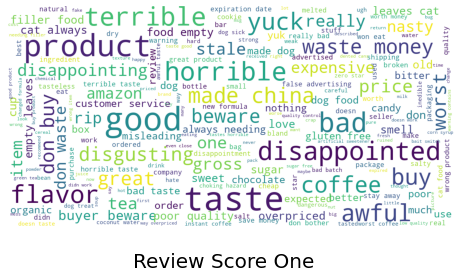

In [ ]:
show_wordcloud(cluster1["Summary_Clean"][0], title = "Review Score One")

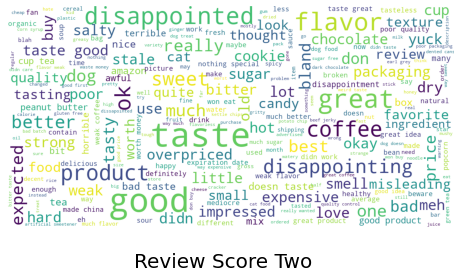

In [ ]:
show_wordcloud(cluster1["Summary_Clean"][1], title = "Review Score Two")

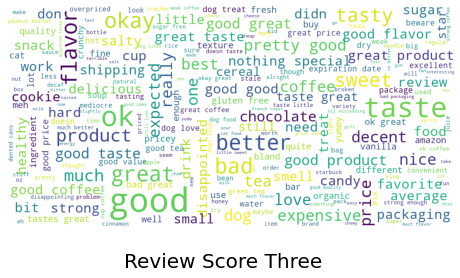

In [ ]:
show_wordcloud(cluster1["Summary_Clean"][2], title="Review Score Three")

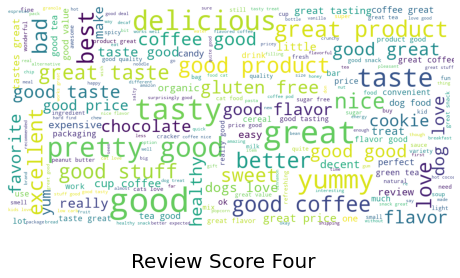

In [ ]:
show_wordcloud(cluster1['Summary_Clean'][3], title = "Review Score Four")

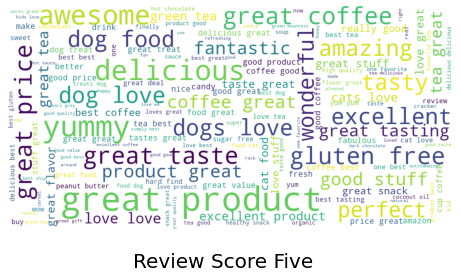

In [ ]:
show_wordcloud(cluster1['Summary_Clean'][4], title="Review Score Five")